<a href="https://colab.research.google.com/github/ZhangEnsure/pytorch-d2l-zh/blob/master/3.%E7%8E%B0%E4%BB%A3%E5%8D%B7%E7%A7%AF%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C/googlenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 含并行连结的网络（GoogLeNet）

Inception块

In [ ]:
%pip install d2l
%pip install matplotlib_inline
%pip install matplotlib==3.0

In [8]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import torchvision
from torchvision import transforms 
from torch.utils import data

class Inception(nn.Module):
  def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
    super(Inception, self).__init__(**kwargs)
    self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
    self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
    self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
    self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
    self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
    self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

  def forward(self, x):
    p1 = F.relu(self.p1_1(x))
    p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
    p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
    p4 = F.relu(self.p4_2(self.p4_1(x)))
    # 沿着 dim=1 维度进行连接，dim=0 是样本数目
    return torch.cat((p1, p2, p3, p4), dim=1)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

def load_data_fashion_mnist(batch_size, resize=None):
  """下载Fashion-MNIST数据集，然后将其加载到内存中
  Defined in :numref:`sec_fashion_mnist`"""
  trans = [transforms.ToTensor()]
  if resize:
      trans.insert(0, transforms.Resize(resize))
  trans = transforms.Compose(trans)
  mnist_train = torchvision.datasets.FashionMNIST(
      root="./drive/MyDrive/Notebooks/data", train=True, transform=trans, download=True)
  mnist_test = torchvision.datasets.FashionMNIST(
      root="./drive/MyDrive/Notebooks/data", train=False, transform=trans, download=True)
  return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                          num_workers=2),
          data.DataLoader(mnist_test, batch_size, shuffle=False,
                          num_workers=2))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


GoogLeNet模型

In [10]:
# stage1 & stage2 --> 图像高宽/4
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

为了使Fashion-MNIST上的训练短小精悍，我们将输入的高和宽从224降到96

In [11]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


训练模型

loss 0.244, train acc 0.907, test acc 0.895
1380.6 examples/sec on cuda:0


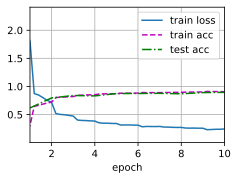

In [13]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())